# Depencency parsing
(парсинг зависимостей)

## Что это?

* наша цель -- представить предложение естественного языка в виде дерева
* слова предложения -- вершины; *зависимости (dependencies)* между ними -- рёбра
* зависимости могут быть разными: например, субъект глагола, объект глагола, прилагательное-модификатор, и так далее

## Формат

Существует несколько форматов записи деревьев зависимостей, но самый популярный и общеиспользуемый -- [CoNLL-U](http://universaldependencies.org/format.html).<br/>
Как это выглядит (пример из [русского Universal Dependency трибанка](https://github.com/UniversalDependencies/UD_Russian-SynTagRus)):

In [1]:
my_example = """
# sent_id = 2003Armeniya.xml_138
# text = Перспективы развития сферы высоких технологий.
1	Перспективы	перспектива	NOUN	_	Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur	0	root	0:root	_
2	развития	развитие	NOUN	_	Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing	1	nmod	1:nmod	_
3	сферы	сфера	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	2	nmod	2:nmod	_
4	высоких	высокий	ADJ	_	Case=Gen|Degree=Pos|Number=Plur	5	amod	5:amod	_
5	технологий	технология	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Plur	3	nmod	3:nmod	SpaceAfter=No
6	.	.	PUNCT	_	_	1	punct	1:punct	_
"""

Комментарии + таблица c 9 колонками (разделители табы):
* ID
* FORM: токен
* LEMMA: начальная форма
* UPOS: универсальная часть речи
* XPOS: лингво-специфичная часть речи
* FEATS: морфологическая информация: падеж, род, число etc
* HEAD: id ролителя
* DEPREL: тип зависимости, то есть отношение к токену-родителю
* DEPS: альтернативный подграф (не будем углубляться :))
* MISC: всё остальное

Отсутствующие данные представляются с помощью `_`. Больше подробностей про формат -- в [официальной документаци](http://universaldependencies.org/format.html).<br>
User-friendly визуализация: ![2003Armeniya.xml_138](rus_tree.png)

Отрытый инструмент для визуализации, ручной разметки и конвертации в другие форматы: UD Annotatrix. [Online-интерфейс](https://maryszmary.github.io/ud-annotatrix/standalone/annotator.html), [репозиторий](https://github.com/jonorthwash/ud-annotatrix).

Трибанк -- много таких предложений. Обычно они разделяются двумя переносами строки.
### Как считывать данные в питоне

Используем библиотеку [conllu](https://github.com/EmilStenstrom/conllu).

In [2]:
!pip3 install conllu
from conllu import parse

In [3]:
help(parse)

Help on function parse in module conllu.parser:

parse(text, fields=('id', 'form', 'lemma', 'upostag', 'xpostag', 'feats', 'head', 'deprel', 'deps', 'misc'))



In [5]:
sentences = parse(my_example)
sentence = sentences[0]
sentence[0]

OrderedDict([('id', 1),
             ('form', 'Перспективы'),
             ('lemma', 'перспектива'),
             ('upostag', 'NOUN'),
             ('xpostag', None),
             ('feats',
              OrderedDict([('Animacy', 'Inan'),
                           ('Case', 'Nom'),
                           ('Gender', 'Fem'),
                           ('Number', 'Plur')])),
             ('head', 0),
             ('deprel', 'root'),
             ('deps', [('root', 0)]),
             ('misc', None)])

In [6]:
sentence[-1]

OrderedDict([('id', 6),
             ('form', '.'),
             ('lemma', '.'),
             ('upostag', 'PUNCT'),
             ('xpostag', None),
             ('feats', None),
             ('head', 1),
             ('deprel', 'punct'),
             ('deps', [('punct', 1)]),
             ('misc', None)])

## Визуализация

В nltk есть DependencyGraph, который умеет рисовать деревья (и ещё многое другое). Для того, чтобы визуализация работала корректно, ему нужна зависимость: graphviz.

```
sudo apt-get install graphviz
pip3 install graphviz
```

In [18]:
from nltk import DependencyGraph

В отличие от `conllu`, `DependencyGraph` не справляется с комментариями, поэтому придётся их убрать.

In [93]:
sents = []
for sent in parsed.split('\n\n'):
    sent = '\n'.join([line for line in sent.split('\n') if not line.startswith('#')])
    sents.append(sent)

/usr/local/lib/python3.5/dist-packages/nltk/parse/dependencygraph.py:380: UserWarning: The graph doesn't contain a node that depends on the root element.
  "The graph doesn't contain a node "


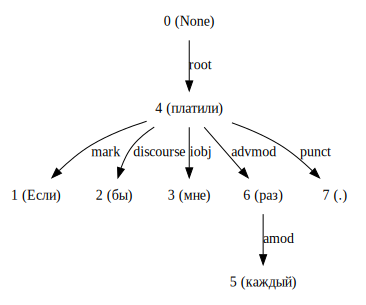

In [95]:
graph = DependencyGraph(tree_str=sents[0])
graph

## UDPipe

Есть разные инструменты для парсинга зависимостей. Сегодня мы будем рабтать с [UDPipe](http://ufal.mff.cuni.cz/udpipe). UDPipe умеет парсить текст с помощью готовых моделей (которые можно скачать [здесь](https://github.com/jwijffels/udpipe.models.ud.2.0/tree/master/inst/udpipe-ud-2.0-170801)) и обучать модели на своих трибанках.

Собственно, в UDPipe есть три вида моделей:
* токенизатор (разделить предложение не токены, сделать заготовку для CoNLL-U)
* тэггер (разметить части речи)
* сам парсер (проставить каждому токену `head` и `deprel`)

Мы сегодня не будем обучать новых моделей (это слишком долго), а используем готовую модель для русского.

### The Python binding

У udpipe есть питоновская обвязка. Она довольно [плохо задокументирована](https://pypi.org/project/ufal.udpipe/), но зато можно использовать прямо в питоне :)

In [7]:
!pip3 install ufal.udpipe
from ufal.udpipe import Model, Pipeline

In [8]:
model = Model.load("russian-ud-2.0-170801.udpipe") # path to the model

In [34]:
# если успех, должно быть так
model

<Swig Object of type 'model *' at 0x7fb174878180>

In [10]:
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')
example = "Если бы мне платили каждый раз. Каждый раз, когда я думаю о тебе."
parsed = pipeline.process(example)
print(parsed)

# newdoc
# newpar
# sent_id = 1
# text = Если бы мне платили каждый раз.
1	Если	ЕСЛИ	SCONJ	IN	_	4	mark	_	_
2	бы	БЫ	PART	RP	_	4	discourse	_	_
3	мне	Я	PRON	PRP	Case=Dat|Number=Sing|Person=1	4	iobj	_	_
4	платили	ПЛАТИТЬ	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin	0	root	_	_
5	каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	amod	_	_
6	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	4	advmod	_	SpaceAfter=No
7	.	.	PUNCT	.	_	4	punct	_	_

# sent_id = 2
# text = Каждый раз, когда я думаю о тебе.
1	Каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	2	amod	_	_
2	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	advmod	_	SpaceAfter=No
3	,	,	PUNCT	,	_	6	punct	_	_
4	когда	КОГДА	ADV	WRB	_	6	advmod	_	_
5	я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	6	nsubj	_	_
6	думаю	дУМАТЬ	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin	0	root	_	_
7	о	О	ADP	IN	_	8	case	_	_
8	тебе	ТЫ	PRON	PRP	Case=Dat|Number=

Как видим, UDPipe и токенизировал, и лематизировал текст, сделал POS-tagging и, собственно, синтаксический парсинг.

### Command line interface

Но с обвязкой бывают проблемы, и вообще довольно удобно пользоваться прекомпилированной утилитой `udpipe` из шелла. Она скачивается [здесь](https://github.com/ufal/udpipe/releases/tag/v1.2.0): (надеюсь, вы уже скачали всё заранее).<br>Внутри бинарники для всех популярных ОС, выбираем свою. У меня путь к бинарнику такой: `~/Documents/udpipe-1.2.0-bin/bin-linux64`.

Синтаксис:

In [11]:
! udpipe

Usage: udpipe [running_opts] model_file [input_files]
       udpipe --train [training_opts] model_file [input_files]
       udpipe --detokenize [detokenize_opts] raw_text_file [input_files]
Running opts: --accuracy (measure accuracy only)
              --input=[conllu|generic_tokenizer|horizontal|vertical]
              --immediate (process sentences immediately during loading)
              --outfile=output file template
              --output=[conllu|epe|matxin|horizontal|plaintext|vertical]
              --tokenize (perform tokenization)
              --tokenizer=tokenizer options, implies --tokenize
              --tag (perform tagging)
              --tagger=tagger options, implies --tag
              --parse (perform parsing)
              --parser=parser options, implies --parse
Training opts: --method=[morphodita_parsito] which method to use
               --heldout=heldout data file name
               --tokenizer=tokenizer options
               --tagger=tagger options
      

Нас сегодня будет интересовать только парсинг, так что типичная команда будет выглядеть так:

In [12]:
with open('example.txt', 'w') as f:
    f.write(example)

! udpipe --tokenize --tag --parse russian-ud-2.0-170801.udpipe example.txt > parsed_example.conllu
! cat parsed_example.conllu

Loading UDPipe model: done.
# newdoc id = example.txt
# newpar
# sent_id = 1
# text = Если бы мне платили каждый раз.
1	Если	ЕСЛИ	SCONJ	IN	_	4	mark	_	_
2	бы	БЫ	PART	RP	_	4	discourse	_	_
3	мне	Я	PRON	PRP	Case=Dat|Number=Sing|Person=1	4	iobj	_	_
4	платили	ПЛАТИТЬ	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin	0	root	_	_
5	каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	amod	_	_
6	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	4	advmod	_	SpaceAfter=No
7	.	.	PUNCT	.	_	4	punct	_	_

# sent_id = 2
# text = Каждый раз, когда я думаю о тебе.
1	Каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	2	amod	_	_
2	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	advmod	_	SpaceAfter=No
3	,	,	PUNCT	,	_	6	punct	_	_
4	когда	КОГДА	ADV	WRB	_	6	advmod	_	_
5	я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	6	nsubj	_	_
6	думаю	дУМАТЬ	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin	0	root	_	_
7	о	О	ADP	IN	_	8

(Ну а потом снова считываем проанализированные предложения питоном).

Вот два способа работать с UDPipe. Choose your fighter! 

## Главред

Главред -- [сервис](https://glvrd.ru/) для корекции стиля текста. Кроме интерфейса, у него есть [API](https://glvrd.ru/api/)!<br>
На этом семинаре мы имплементируем несколько функций, делающих нечто похожее, на основе синтаксиса.

Возьмём простой пример: предложение, перегруженное однородными членами.

In [13]:
conj = 'Я пришла, включила компьютер, открыла почту, прочитала письмо, налила чай.'
print(pipeline.process(conj))

# newdoc
# newpar
# sent_id = 1
# text = Я пришла, включила компьютер, открыла почту, прочитала письмо, налила чай.
1	Я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	2	nsubj	_	_
2	пришла	приИДТИ	VERB	VBC	Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	0	root	_	SpaceAfter=No
3	,	,	PUNCT	,	_	4	punct	_	_
4	включила	включила	VERB	VBC	Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	2	conj	_	_
5	компьютер	компьютер	NOUN	NN	Animacy=Anim|Case=Gen|Gender=Fem|Number=Plur	4	obj	_	SpaceAfter=No
6	,	,	PUNCT	,	_	7	punct	_	_
7	открыла	открЫТЬ	VERB	VBC	Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	4	conj	_	_
8	почту	почТОТ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing	7	obj	_	SpaceAfter=No
9	,	,	PUNCT	,	_	10	punct	_	_
10	прочитала	прочитала	VERB	VBC	Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	2	conj	_	_
11	письмо	ПИСЬМО	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing	10	obj	_	SpaceAfter=No
12	,	,	PUNCT	,	_	13	p

В таком случае очень много частей предложения, соединённых связью `conj` -- ей обозначаются однородные члены предложения. В таком случае можно просто посчитать количество таких связей:

In [ ]:
def count_conj(sentence):
    # your code here

Ещё одна проблема, на которую обращают внимание в Главреде -- [парцелляция](http://maximilyahov.ru/blog/all/parcel/). Часто она делает предложения менее читаемыми.

По словам Главреда,
> Признак парцелляции — предложение синтаксически неполное и само по себе не имеет смысла.

Например, в предложении нет субъекта:

In [35]:
ex = 'Выключил компьютер и заснул.'
print(pipeline.process(ex))

# newdoc
# newpar
# sent_id = 1
# text = Выключил компьютер и заснул.
1	Выключил	Выключил	VERB	VBC	Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	0	root	_	_
2	компьютер	компьютер	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	1	obj	_	_
3	и	И	CCONJ	CC	_	4	cc	_	_
4	заснул	заснУЛ	VERB	VBC	Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	1	conj	_	SpaceAfter=No
5	.	.	PUNCT	.	_	1	punct	_	SpacesAfter=\n




Или вообще что-то странное:

In [45]:
ex = 'А броско, шикарно и выделяля бы вас из толпы'
print(pipeline.process(ex))

# newdoc
# newpar
# sent_id = 1
# text = А броско, шикарно и выделяля бы вас из толпы
1	А	А	CCONJ	CC	_	2	cc:preconj	_	_
2	броско	броско	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing	0	root	_	SpaceAfter=No
3	,	,	PUNCT	,	_	4	punct	_	_
4	шикарно	шикаРНО	ADV	RB	_	2	conj	_	_
5	и	И	CCONJ	CC	_	6	cc	_	_
6	выделяля	выделяля	ADP	IN	_	8	case	_	_
7	бы	БЫ	PART	RP	_	8	discourse	_	_
8	вас	ВЫ	PRON	PRP	Case=Acc|Number=Plur|Person=2	2	nmod	_	_
9	из	ИЗ	ADP	IN	_	10	case	_	_
10	толпы	толпы	NOUN	NN	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	2	nmod	_	SpacesAfter=\n




Напишите функцию, которая помогает обнаруживать парцелляцию, опираясь на то, что предложение неполное:

А теперь давайте усложним критерий на однородные члены: проверим, не состоит ли предложение из большого числа однородных предложений. Для этого проверим, являются ли однородные члены глаголами.

Придумайте метрику для оценки качества предложений на основе написаных функций. Напишите функцию-оцениватель. Пусть она принимает на вход предложение, а возвращает оценку от 1 до 10.

In [ ]:
def get_score(sentence):
    # your code here
    return score

Если осталось время, придумайте и напишите свою функцию, которая помогала бы оценивать качество текста. Добавьте её в метрику.